# Import bibliotek

In [ ]:
import os
import random
import glob
import pandas as pd
import numpy as np
import math
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import networkx as nx

import matplotlib.pyplot as plt

# Ustawienie opcji wyświetlania i wczytanie danych

In [2]:
# Ustawienie opcji wyświetlania
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Wczytanie danych
df = pd.read_json('C:\\Users\\justy\\Documents\\Projekt\\04_projekt_znormalizowane_i_wybrane_kolumny_do_końcowej_analizy.json')

In [4]:
df.head()

,rozpoznania_pooperacyjne,zakres_operacji,Czy_dolegliwosci,dolegliwości,Rodzaj_operacji,Czy_leczenie_hormonalne,Czy_dietetyk,Okres_dietetyk,Czy_dieta_własna,Czy_Fizjoterapeuta_po_operacji,Okres_fizjoterapeuta,Aktywnosc_fizyczna,Czy_inne_metody,dodatkowe_metody,Czy_warzywa_i_owoce_5_porcji,Czy_inne_choroby,dodatkowe_choroby_i_zaburzenia,Ile_operacji,Czy_operacja_zwiadowcza,Ile_po_operacji,"Zdrowe_srodowisko (0 Nie, 1 Tak)",BMI_kategoria,Grupa_wiekowa
0,"endometrioza, endometrioza jajnika, endometrioza szyjki macicy, głęboko naciekająca endometrioza (die), zrosty","adhezioliza, wycięcie endometriozy z obustronnego parametrium, histerektomia, zapobieganie zrostom, drenaż jamy otrzewnej",nie,None,laparoskopia,tak -> ciągle do pół roku po operacji,tak,ciągle do pół roku po operacji,nie,nie,None,ćwiczę więcej niż 3 razy w tygodniu i/lub średnio robię co najmniej 10 tys kroków dziennie.,nie,None,tak,tak,"nadciśnienie, torbiele mózgu, guzy płuc",4,nie,od 2 lat do 3 lat,0,wartość prawidłowa,40-49 lat
1,"ból brzucha, choroba otrzewnej, endometrioza","wycięcie tkanki otrzewnej, adhezyoliza, wycięcie lewego więzadła krzyżowo-macicznego i otrzewnej z zatoki douglasa, wycięcie otrzewnej z przedniej ściany jamy brzusznej",nie,None,laparoskopia,tak -> ciągle do pół roku po operacji,tak,ciągle do pół roku po operacji,None,tak,byłam kilka razy u osteopaty/fizjoterapeuty w okresie do pół roku po operacji.,ćwiczę 3 razy w tygodniu i/lub średno robię więcej niż 7 tys kroków dziennie.,tak,"psychoterapia, akupunktura, joga, fizjoterapia, terapia konopna, medytacja",tak,tak,"niedoczynność tarczycy, przewlekłe zapalenie wątroby",2,nie,do pół roku,0,wartość prawidłowa,30-39 lat
2,"endometrioza jajnika, endometrioza jelitowa, przemieszczenie pęcherza moczowego, zaawansowana endometrioza, zrosty","adhezioliza, salpingo-ooforektomia po lewej stronie, wycięcie endometriozy z prawego jajnika, salpingo-ooforektomia po prawej stronie, przezodbytnicza resekcja dysku odbytnicy, histerektomia, trachelektomia, adhezioliza i repozycja pęcherza moczowego",tak,"ból pleców, problemy z oddawaniem moczu, zatrzymanie moczu, ból moczowodowy, ból nerek",laparoskopia,tak -> ciągle powyżej dwóch lat po operacji,nie,None,tak,tak,byłam wielokrotnie u osteopaty/fizjoterapeuty w okresie do pół roku po operacji oraz w późniejszym okresie.,ćwiczę 1 raz w tygodniu i/lub średnio robię więcej niż 2 tys kroków dziennie.,tak,"terapia masażem, akupunktura, naturoterapia, suplementy",tak,nie,None,1,nie,od 1 roku do 2 lat,0,nadwaga,30-39 lat
3,"adenomioza, endometrioza jajnika, głęboko naciekająca endometrioza (die), zrosty","adhezioliza, histerektomia, wycięcie endometriozy z jajników i przydatków, zapobieganie zrostom, drenaż otrzewnowy",tak,"ostry ból, zimne poty, zaparcia",laparoskopia,nie,nie,None,tak,nie,None,ćwiczę 3 razy w tygodniu i/lub średno robię więcej niż 7 tys kroków dziennie.,nie,None,tak,nie,None,1,nie,od 2 lat do 3 lat,0,niedowaga,30-39 lat
4,"endometrioza jajnika, endometrioza jelitowa, głęboko naciekająca endometrioza (die), polip endometrialny, zrosty","adhezioliza, wycięcie torbieli prawego jajnika, resekcja segmentalna odbytnicy, wycięcie głęboko naciekającej endometriozy z jelita, operacja zatoki douglasa, wycięcie więzadeł krzyżowo-macicznych",nie,None,laparoskopia,nie,nie,None,tak,tak,byłam tylko jeden raz u osteopaty/fizjoterapeuty w okresie do pół roku po operacji.,ćwiczę 2 razy w tygodniu i/lub średnio robię więcej niż 5 tys kroków dziennie.,nie,None,tak,tak,insulinooporność,2,nie,od pół roku do 1 roku,0,nadwaga,20-29 lat


# Obróbka datafremu

Do analizy reguł asocjacyjnych teksty w kolumnach opisowych potrzebuję jako listy (czyli np. listy dolegliwości), dlatego w pierwszej kolejności teksty zostaną zamienione na listy

In [5]:
# Lista kolumn, które chcę przekształcić
columns_to_transform = ['rozpoznania_pooperacyjne', 'zakres_operacji', 'dolegliwości', 'dodatkowe_metody', 'dodatkowe_choroby_i_zaburzenia']

# Zastosowanie transformacji do kilku kolumn
for col in columns_to_transform:
    df[col] = df[col].apply(lambda x: x.split(', ') if isinstance(x, str) else [] if pd.notna(x) else [])
    
df.head()

,rozpoznania_pooperacyjne,zakres_operacji,Czy_dolegliwosci,dolegliwości,Rodzaj_operacji,Czy_leczenie_hormonalne,Czy_dietetyk,Okres_dietetyk,Czy_dieta_własna,Czy_Fizjoterapeuta_po_operacji,Okres_fizjoterapeuta,Aktywnosc_fizyczna,Czy_inne_metody,dodatkowe_metody,Czy_warzywa_i_owoce_5_porcji,Czy_inne_choroby,dodatkowe_choroby_i_zaburzenia,Ile_operacji,Czy_operacja_zwiadowcza,Ile_po_operacji,"Zdrowe_srodowisko (0 Nie, 1 Tak)",BMI_kategoria,Grupa_wiekowa
0,"[endometrioza, endometrioza jajnika, endometrioza szyjki macicy, głęboko naciekająca endometrioza (die), zrosty]","[adhezioliza, wycięcie endometriozy z obustronnego parametrium, histerektomia, zapobieganie zrostom, drenaż jamy otrzewnej]",nie,[],laparoskopia,tak -> ciągle do pół roku po operacji,tak,ciągle do pół roku po operacji,nie,nie,None,ćwiczę więcej niż 3 razy w tygodniu i/lub średnio robię co najmniej 10 tys kroków dziennie.,nie,[],tak,tak,"[nadciśnienie, torbiele mózgu, guzy płuc]",4,nie,od 2 lat do 3 lat,0,wartość prawidłowa,40-49 lat
1,"[ból brzucha, choroba otrzewnej, endometrioza]","[wycięcie tkanki otrzewnej, adhezyoliza, wycięcie lewego więzadła krzyżowo-macicznego i otrzewnej z zatoki douglasa, wycięcie otrzewnej z przedniej ściany jamy brzusznej]",nie,[],laparoskopia,tak -> ciągle do pół roku po operacji,tak,ciągle do pół roku po operacji,None,tak,byłam kilka razy u osteopaty/fizjoterapeuty w okresie do pół roku po operacji.,ćwiczę 3 razy w tygodniu i/lub średno robię więcej niż 7 tys kroków dziennie.,tak,"[psychoterapia, akupunktura, joga, fizjoterapia, terapia konopna, medytacja]",tak,tak,"[niedoczynność tarczycy, przewlekłe zapalenie wątroby]",2,nie,do pół roku,0,wartość prawidłowa,30-39 lat
2,"[endometrioza jajnika, endometrioza jelitowa, przemieszczenie pęcherza moczowego, zaawansowana endometrioza, zrosty]","[adhezioliza, salpingo-ooforektomia po lewej stronie, wycięcie endometriozy z prawego jajnika, salpingo-ooforektomia po prawej stronie, przezodbytnicza resekcja dysku odbytnicy, histerektomia, trachelektomia, adhezioliza i repozycja pęcherza moczowego]",tak,"[ból pleców, problemy z oddawaniem moczu, zatrzymanie moczu, ból moczowodowy, ból nerek]",laparoskopia,tak -> ciągle powyżej dwóch lat po operacji,nie,None,tak,tak,byłam wielokrotnie u osteopaty/fizjoterapeuty w okresie do pół roku po operacji oraz w późniejszym okresie.,ćwiczę 1 raz w tygodniu i/lub średnio robię więcej niż 2 tys kroków dziennie.,tak,"[terapia masażem, akupunktura, naturoterapia, suplementy]",tak,nie,[],1,nie,od 1 roku do 2 lat,0,nadwaga,30-39 lat
3,"[adenomioza, endometrioza jajnika, głęboko naciekająca endometrioza (die), zrosty]","[adhezioliza, histerektomia, wycięcie endometriozy z jajników i przydatków, zapobieganie zrostom, drenaż otrzewnowy]",tak,"[ostry ból, zimne poty, zaparcia]",laparoskopia,nie,nie,None,tak,nie,None,ćwiczę 3 razy w tygodniu i/lub średno robię więcej niż 7 tys kroków dziennie.,nie,[],tak,nie,[],1,nie,od 2 lat do 3 lat,0,niedowaga,30-39 lat
4,"[endometrioza jajnika, endometrioza jelitowa, głęboko naciekająca endometrioza (die), polip endometrialny, zrosty]","[adhezioliza, wycięcie torbieli prawego jajnika, resekcja segmentalna odbytnicy, wycięcie głęboko naciekającej endometriozy z jelita, operacja zatoki douglasa, wycięcie więzadeł krzyżowo-macicznych]",nie,[],laparoskopia,nie,nie,None,tak,tak,byłam tylko jeden raz u osteopaty/fizjoterapeuty w okresie do pół roku po operacji.,ćwiczę 2 razy w tygodniu i/lub średnio robię więcej niż 5 tys kroków dziennie.,nie,[],tak,tak,[insulinooporność],2,nie,od pół roku do 1 roku,0,nadwaga,20-29 lat


W pierwszej kolejności zostanie wykonana analiza asocjacyjna dla poszczególnych rodzajów dolegliwości, a w drugiej kolejności zostanie wykonana analiza asocjacyjna dla występowania w ogóle dolegliwości, lub ich niewystępowania (dolegliwości: TAK/NIE).

# I. Analiza asocjacyjna dla rodzajów dolegliwości

W pierwszej kolejności zostanie wykonana analiza dla każdego z czynników osobno, w drugiej kolejności dla całej grupy czynników.

In [ ]:
# Funkcja do wstępnego przetwarzania danych
def preprocess_data(df, symptoms_col, specific_symptoms_col, factor_columns):
    # Filtrowanie wierszy, gdzie "symptoms_col" == "tak"
    df_filtered = df[df[symptoms_col].apply(lambda x: "tak" in x)].copy()

    # Zamiana None/NaN oraz pojedynczych wartości na listy
    for col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].apply(
            lambda x: [] if (x is None or (isinstance(x, float) and np.isnan(x)))
            else [x] if not isinstance(x, (list, np.ndarray)) else x
        )

    # Dodanie prefiksów do wartości dla zachowania kontekstu
    for col in factor_columns:
        df_filtered[col] = df_filtered[col].apply(lambda x: [f"{col}:{val}" for val in x])

    # Dodanie prefiksu dla konkretnych dolegliwości
    df_filtered[specific_symptoms_col] = df_filtered[specific_symptoms_col].apply(
        lambda x: [f"Specific_Symptom:{val}" for val in x]
    )

    # Scalanie kolumn w jedną listę transakcji
    df_filtered['Combined'] = df_filtered[factor_columns].apply(lambda row: sum(row, []), axis=1)
    df_filtered['Combined'] = df_filtered.apply(
        lambda row: row['Combined'] + row[specific_symptoms_col], axis=1
    )
    return df_filtered

In [7]:
# Główne wywołanie, ale dla reguł: min_support=0.06, min_confidence=0.7
def process_columns_lower(df, symptoms_col, specific_symptoms_col, factor_columns):
    df_filtered = preprocess_data(df, symptoms_col, specific_symptoms_col, factor_columns)
    final_rules = generate_rules_lower(df_filtered, specific_symptoms_col)
    return final_rules

In [8]:
# Główne wywołanie, ale dla reguł min_support=0.07, min_confidence=0.85 (bo mam tak i tak)
def process_columns(df, symptoms_col, specific_symptoms_col, factor_columns):
    df_filtered = preprocess_data(df, symptoms_col, specific_symptoms_col, factor_columns)
    final_rules = generate_rules(df_filtered, specific_symptoms_col)
    return final_rules

In [ ]:
# Funkcja do generowania reguł asocjacyjnych dla min_support=0.06, min_confidence=0.7 -> będzie wykorzystana dla badania reguł asocjacyjnych dla każdego z czynników z osobna
def generate_rules_lower(df_filtered, specific_symptoms_col, min_support=0.06, min_confidence=0.7):
    # Konwersja transakcji na macierz True/False
    encoder = TransactionEncoder()
    transactions = df_filtered['Combined'].tolist()
    encoded_array = encoder.fit_transform(transactions)
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.columns_)

    # Generowanie częstych zestawów
    supports = apriori(encoded_df, min_support=min_support, use_colnames=True)

    # Generowanie reguł asocjacyjnych
    rules = association_rules(supports, metric='confidence', min_threshold=min_confidence)

    # Filtracja reguł
    specific_symptoms_set = set(df_filtered[specific_symptoms_col].explode().dropna().unique())
    filtered_rules = rules[
        rules['consequents'].apply(lambda x: specific_symptoms_set.issuperset(x)) &
        rules['antecedents'].apply(lambda x: not specific_symptoms_set.intersection(x))
    ]

    # Sortowanie wyników według lift
    filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)
    return filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

In [ ]:
# Funkcja do generowania reguł asocjacyjnych dla min_support=0.07, min_confidence=0.85 (dla całości; dla każdego z czynników z osobna musi być niższe bo by było wykrywanych bardzo niewiele zależności)
def generate_rules(df_filtered, specific_symptoms_col, min_support=0.07, min_confidence=0.85):
    encoder = TransactionEncoder()
    transactions = df_filtered['Combined'].tolist()
    encoded_array = encoder.fit_transform(transactions)
    encoded_df = pd.DataFrame(encoded_array, columns=encoder.columns_)
    
    supports = apriori(encoded_df, min_support=min_support, use_colnames=True)
    rules = association_rules(supports, metric='confidence', min_threshold=min_confidence)
    
    specific_symptoms_set = set(df_filtered[specific_symptoms_col].explode().dropna().unique())
    filtered_rules = rules[
        rules['consequents'].apply(lambda x: specific_symptoms_set.issuperset(x)) &
        rules['antecedents'].apply(lambda x: not specific_symptoms_set.intersection(x))
    ]
    
    filtered_rules = filtered_rules.sort_values(by='lift', ascending=False)
    return filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]

## I.1. Analiza asocjacyjna dla każdego z czynników osobno:

In [ ]:
# Lista kolumn do przetwarzania
columns_to_process = ['rozpoznania_pooperacyjne', 'zakres_operacji',
       'dolegliwości', 'Rodzaj_operacji', 'Czy_leczenie_hormonalne',
       'Czy_dietetyk', 'Okres_dietetyk', 'Czy_dieta_własna',
       'Czy_Fizjoterapeuta_po_operacji', 'Okres_fizjoterapeuta',
       'Aktywnosc_fizyczna', 'Czy_inne_metody', 'dodatkowe_metody',
       'Czy_warzywa_i_owoce_5_porcji', 'Czy_inne_choroby',
       'dodatkowe_choroby_i_zaburzenia', 'Ile_operacji',
       'Czy_operacja_zwiadowcza', 'Ile_po_operacji',
       'Zdrowe_srodowisko (0 Nie, 1 Tak)', 'BMI_kategoria', 'Grupa_wiekowa']

# Tworzenie folderu "results" na wyniki
os.makedirs("results", exist_ok=True)

# Iteracja przez kolumny i zapis wyników do plików CSV, tylko w przypadku jeśli są wyniki (jeśli jest zero to nie tworzy pliku i nie zapisuje w folderze results)
for col in columns_to_process:
    try:
        print(f"Przetwarzanie kolumny: {col}")
        rules = process_columns_lower(df, 'Czy_dolegliwosci', 'dolegliwości', [col])
        if not rules.empty:
            output_file = os.path.join("results", f"rules_{col}.csv")
            rules.to_csv(output_file, index=False)
            print(f"Wyniki zapisano w pliku: {output_file}")
            print(f"Liczba znalezionych reguł: {len(rules)}")
        else:
            print(f"Nie znaleziono żadnych reguł dla kolumny: {col}")
    except Exception as e:
        print(f"Wystąpił błąd podczas przetwarzania kolumny {col}: {e}")


Przetwarzanie kolumny: rozpoznania_pooperacyjne
Wyniki zapisano w pliku: results\rules_rozpoznania_pooperacyjne.csv
Liczba znalezionych reguł: 13
Przetwarzanie kolumny: zakres_operacji
Wyniki zapisano w pliku: results\rules_zakres_operacji.csv
Liczba znalezionych reguł: 2
Przetwarzanie kolumny: dolegliwości
Nie znaleziono żadnych reguł dla kolumny: dolegliwości
Przetwarzanie kolumny: Rodzaj_operacji
Wyniki zapisano w pliku: results\rules_Rodzaj_operacji.csv
Liczba znalezionych reguł: 1
Przetwarzanie kolumny: Czy_leczenie_hormonalne
Wyniki zapisano w pliku: results\rules_Czy_leczenie_hormonalne.csv
Liczba znalezionych reguł: 1
Przetwarzanie kolumny: Czy_dietetyk
Nie znaleziono żadnych reguł dla kolumny: Czy_dietetyk
Przetwarzanie kolumny: Okres_dietetyk
Wyniki zapisano w pliku: results\rules_Okres_dietetyk.csv
Liczba znalezionych reguł: 1
Przetwarzanie kolumny: Czy_dieta_własna
Wyniki zapisano w pliku: results\rules_Czy_dieta_własna.csv
Liczba znalezionych reguł: 1
Przetwarzanie kolumny

Wyświetlę top 50 reguł asocjacyjnych posortofanych malejąco po confidence i support:

In [10]:
# Ścieżka do folderu results
folder_path = "results"

# Pobranie wszystkich plików CSV w folderze
files = glob.glob(os.path.join(folder_path, "*.csv"))

# Lista do przechowywania danych
all_rules = []

# Wczytanie i scalanie danych z wszystkich plików
for file in files:
    df_rules = pd.read_csv(file)
    
    # Sprawdzenie, czy kolumna confidence istnieje
    if 'confidence' in df_rules.columns:
        all_rules.append(df_rules)
    else:
        print(f"Ostrzeżenie: Plik {file} nie zawiera kolumny 'confidence' i został pominięty.")

# Sprawdzenie, czy wczytano jakiekolwiek dane
if all_rules:
    # Połączenie wszystkich reguł w jeden DataFrame
    rules_df = pd.concat(all_rules, ignore_index=True)

    # Posortowanie według confidence malejąco, a potem po support
    rules_df = rules_df.sort_values(by=["confidence", "support"], ascending=[False, False])

    # Pobranie 50 pierwszych reguł (jeśli będzie mniej to pobierze mniej)
    top_50_rules = rules_df.head(50)
else:
    # Ustawienie pustego DataFrame, aby uniknąć błędu
    top_50_rules = pd.DataFrame()

# Wyświetlenie wyników (zawsze działa, nawet jeśli brak danych)
top_50_rules


,antecedents,consequents,support,confidence,lift
5,frozenset({'dodatkowe_metody:akupunktura'}),frozenset({'Specific_Symptom:ból pleców'}),0.096774,1.00,3.875000
8,frozenset({'Okres_dietetyk:ciągle do pół roku po operacji'}),frozenset({'Specific_Symptom:ból pleców'}),0.096774,1.00,3.875000
2,frozenset({'Czy_leczenie_hormonalne:tak -> ciągle do dwóch lat po operacji'}),frozenset({'Specific_Symptom:zaparcia'}),0.064516,1.00,3.875000
3,"frozenset({'dodatkowe_choroby_i_zaburzenia:sibo', 'dodatkowe_choroby_i_zaburzenia:depresja'})",frozenset({'Specific_Symptom:ból brzucha'}),0.064516,1.00,3.444444
6,frozenset({'dodatkowe_metody:terapia masażem'}),frozenset({'Specific_Symptom:ból pleców'}),0.064516,1.00,3.875000
7,"frozenset({'dodatkowe_metody:medytacja', 'dodatkowe_metody:akupunktura'})",frozenset({'Specific_Symptom:ból pleców'}),0.064516,1.00,3.875000
9,frozenset({'Okres_fizjoterapeuta:byłam kilka razy u osteopaty/fizjoterapeuty w okresie do pół roku po operacji.'}),frozenset({'Specific_Symptom:ból pleców'}),0.064516,1.00,3.875000
10,frozenset({'Rodzaj_operacji:laparoskopia;laparotomia'}),frozenset({'Specific_Symptom:ból pleców'}),0.064516,1.00,3.875000
11,"frozenset({'rozpoznania_pooperacyjne:adenomioza', 'rozpoznania_pooperacyjne:zrosty', 'rozpoznania_pooperacyjne:endometrioza jelitowa'})",frozenset({'Specific_Symptom:częstomocz'}),0.064516,1.00,10.333333
12,"frozenset({'rozpoznania_pooperacyjne:adenomioza', 'rozpoznania_pooperacyjne:głęboko naciekająca endometrioza (die)', 'rozpoznania_pooperacyjne:zrosty', 'rozpoznania_pooperacyjne:endometrioza jelitowa'})",frozenset({'Specific_Symptom:częstomocz'}),0.064516,1.00,10.333333


In [11]:
#Zapisanie wyniku do pliku csv
top_50_rules.to_csv("top_50_reguł_dolegliwości.csv", index=False)

Z tabeli z regułami asocjacyjnymi bardzo trudno wywnioskować powiązania. Dużo łatwiej będzie stwierdzić jakie są reguły dzięki wizualizacji w postaci grafów.

### Wykonanie grafów obrazujących powiązania między dolegliwościami (ich rodzajami), a różnymi czynnikami (grafy powiązań):

In [12]:
# Funkcja do pobrania nazw plików w folderze 'results' i usunięcia przedrostka 'rules_'
def get_columns_from_results_folder(result_folder):
    columns = []
    if os.path.exists(result_folder):
        for file in os.listdir(result_folder):
            if file.endswith(".csv") and file.startswith("rules_"):
                # Usunięcie przedrostka 'rules_' oraz rozszerzenia '.csv'
                col_name = file.replace("rules_", "").replace(".csv", "")
                columns.append(col_name)
    return columns

In [13]:
def save_graph_to_csv(G, col_name):
    # Utwórz folder 'grafy', jeśli nie istnieje
    folder_name = "grafy"
    os.makedirs(folder_name, exist_ok=True)
    
    # Zapis węzłów
    nodes = pd.DataFrame({
        'node_id': list(G.nodes),
        'type': ['symptom' if "Symptom:" in node else 'factor' for node in G.nodes]
    })
    nodes.to_csv(f"{folder_name}/{col_name}_nodes.csv", index=False)

    # Zapis krawędzi
    edges = pd.DataFrame(
        [(u, v, d['lift'], d['confidence']) for u, v, d in G.edges(data=True)],
        columns=['source', 'target', 'lift', 'confidence']
    )
    edges.to_csv(f"{folder_name}/{col_name}_edges.csv", index=False)

In [14]:
def prepare_graph_elements(rules):
    G = nx.Graph()
    
    for _, row in rules.iterrows():
        antecedents = row['antecedents']
        consequents = row['consequents']
        
        for a in antecedents:
            G.add_node(a, type="cause")
        for c in consequents:
            G.add_node(c, type="effect")
        for a in antecedents:
            for c in consequents:
                G.add_edge(a, c, effect=c)  # Oznaczamy krawędź przez skutek
    
    degrees = dict(G.degree())
    return G, degrees

In [15]:
# Funkcja do ekstrakcji tekstu po dwukropku
def extract_label_from_node(node):
    return node.split(":")[1].strip() if ":" in node else node

In [16]:
# Przygotowanie danych dla różnych kolumn
# Pobranie dostępnych kolumn z folderu 'results'
result_folder = "results"
columns_to_process = get_columns_from_results_folder(result_folder)
columns_to_process



['BMI_kategoria',
 'Czy_dieta_własna',
 'Czy_leczenie_hormonalne',
 'dodatkowe_choroby_i_zaburzenia',
 'dodatkowe_metody',
 'Okres_dietetyk',
 'Okres_fizjoterapeuta',
 'Rodzaj_operacji',
 'rozpoznania_pooperacyjne',
 'zakres_operacji']

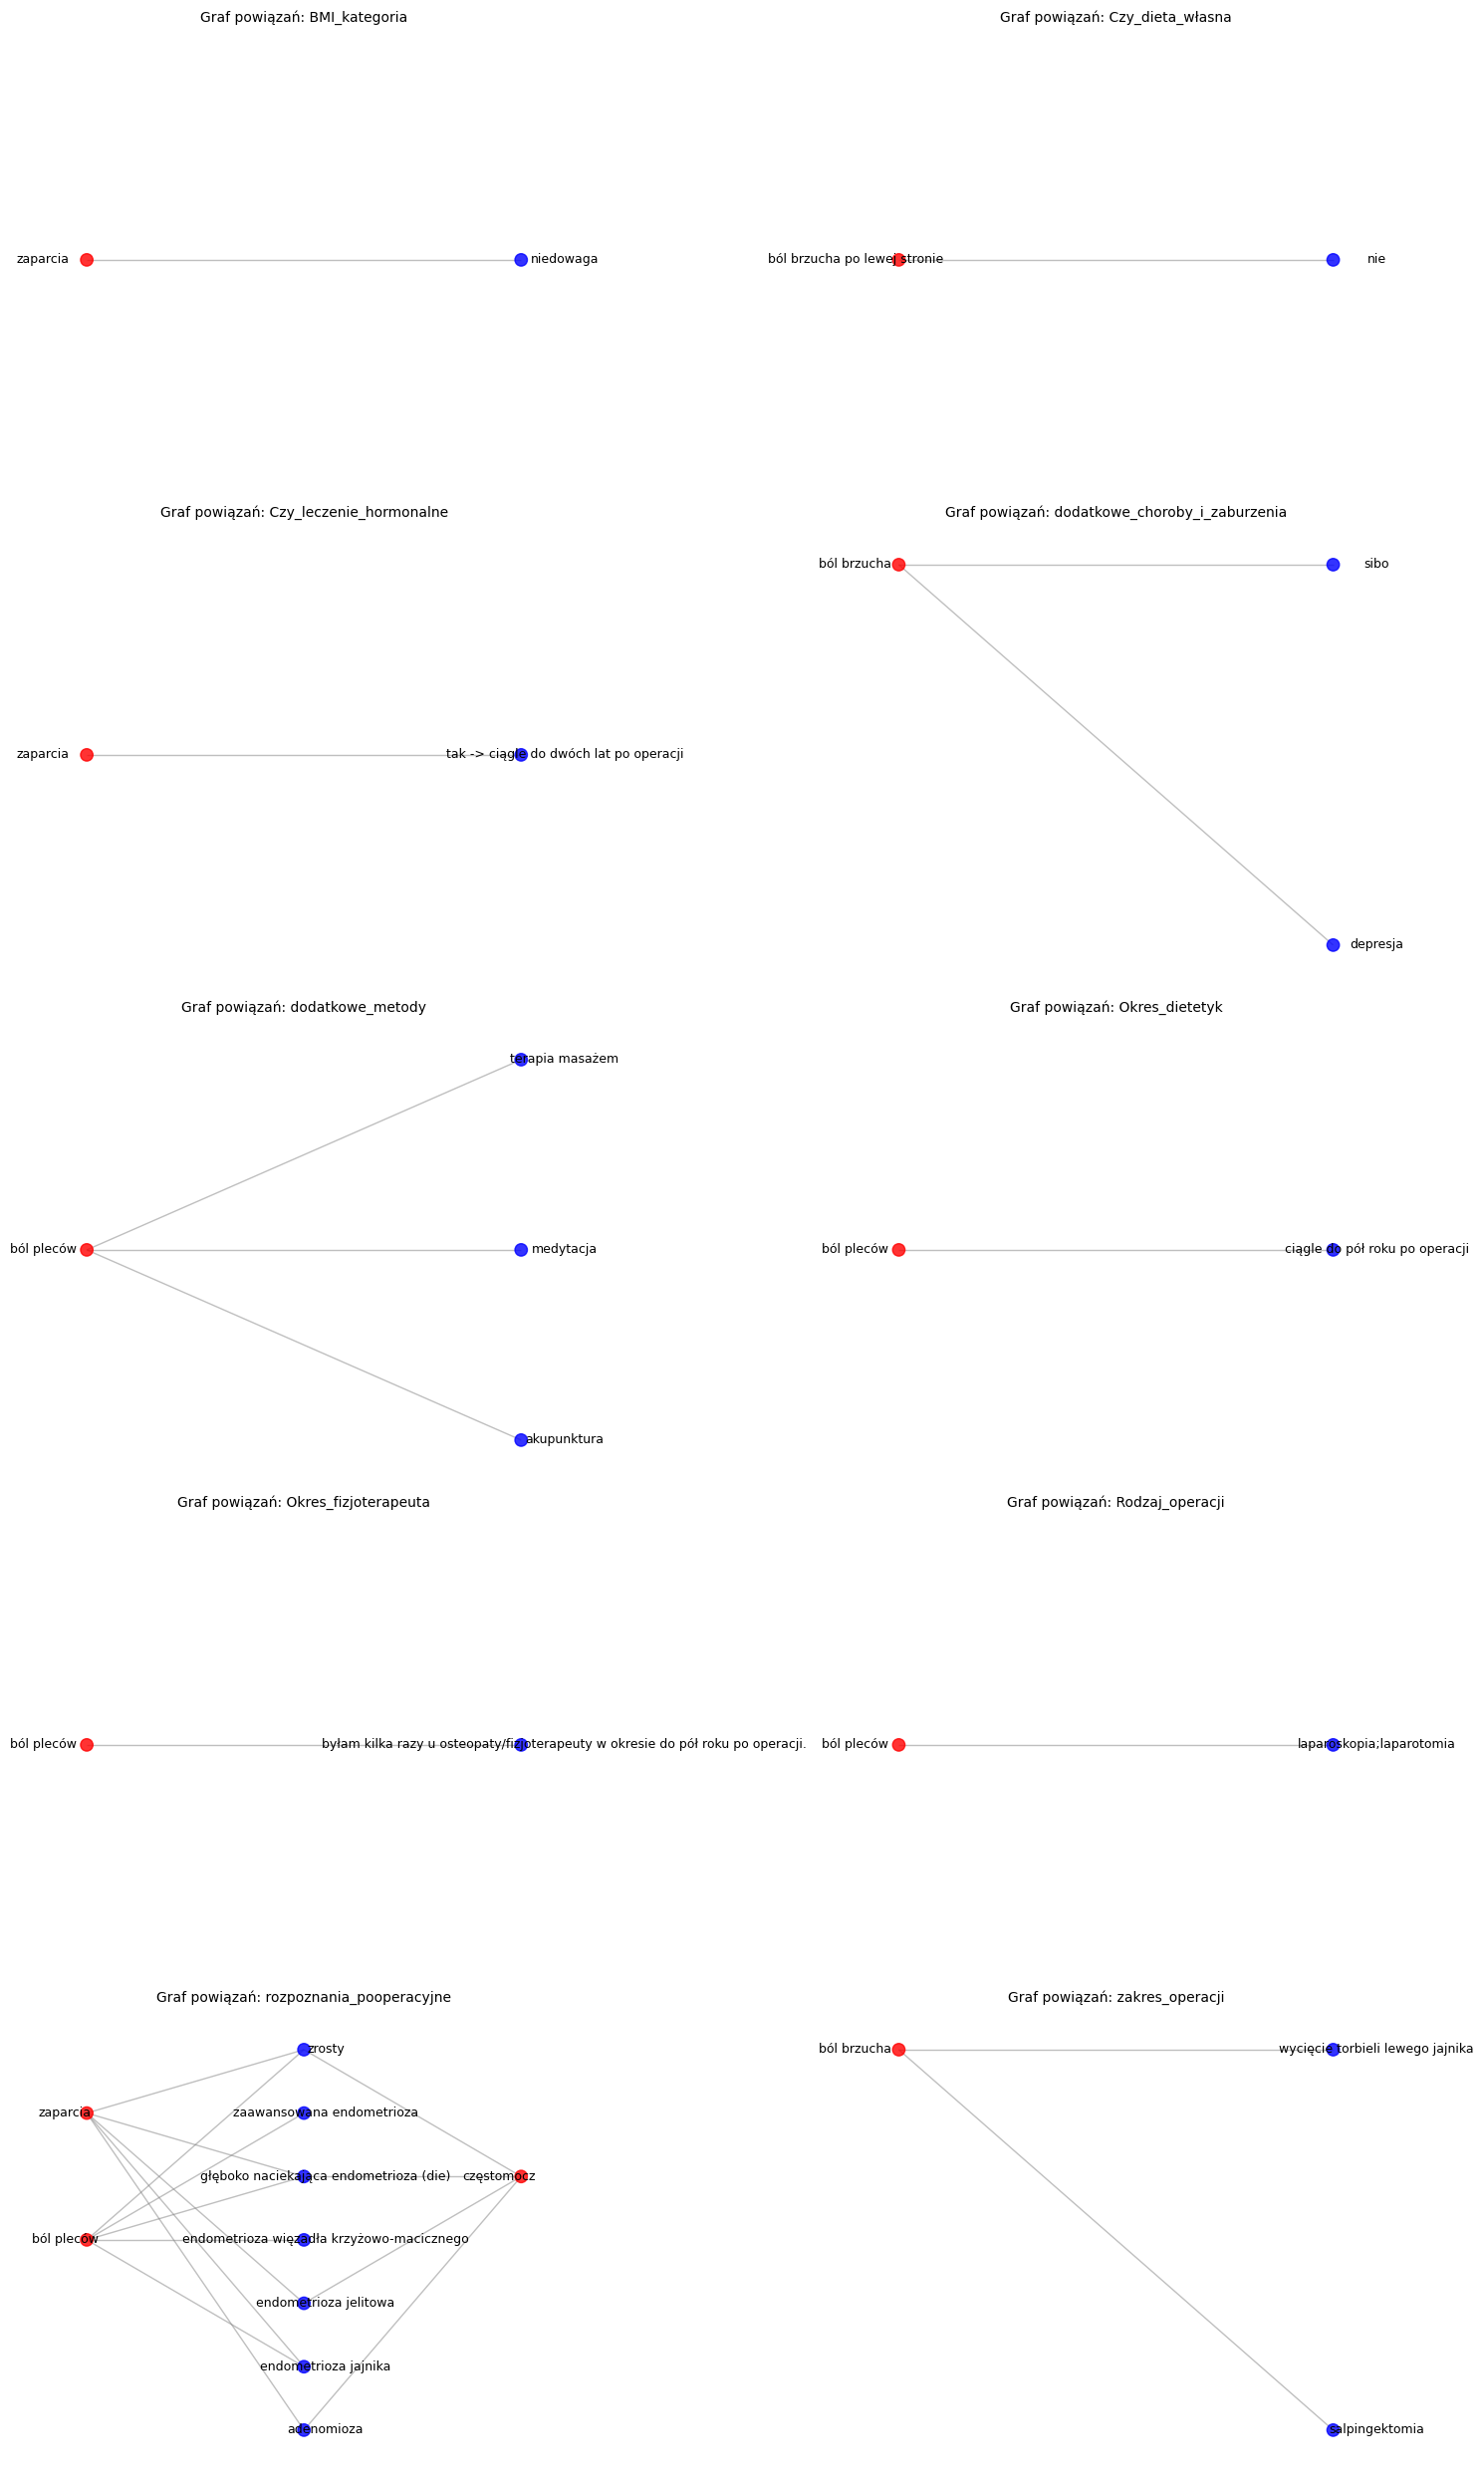

In [17]:
# Folder z plikami CSV
folder_path = "C:\\Users\\justy\\Documents\\Projekt\\results"

# Pobranie listy plików CSV w folderze
files_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Sprawdzenie, ile plików jest w folderze
num_files = len(files_paths)

if num_files == 0:
    print("Brak plików CSV w folderze.")
else:
    # Ustalanie liczby wierszy i kolumn w siatce
    ncols = 2  # Stała liczba kolumn
    nrows = math.ceil(num_files / ncols)  # Obliczenie liczby wierszy

    # Tworzenie dynamicznej figury
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()  # Spłaszczenie listy osi dla łatwiejszego indeksowania

    # Przetwarzanie każdego pliku
    for idx, file_path in enumerate(files_paths):
        # Wczytanie i przetworzenie pliku CSV
        rules = pd.read_csv(file_path)

        # Konwersja kolumn na listy
        if 'antecedents' in rules.columns and 'consequents' in rules.columns:
            rules['antecedents'] = rules['antecedents'].apply(eval)
            rules['consequents'] = rules['consequents'].apply(eval)

            # Generowanie elementów grafu
            G, degrees = prepare_graph_elements(rules)
        else:
            print(f"Błąd: brak wymaganych kolumn w pliku {file_path}.")
            continue

		#Chcę aby węzły były ustawione w pionie, przy czym przyczyny (consequents) w środku, a skutki raz po prawej, raz po lewej dla poprawy czytelności grafu:
        
        # Ustalanie pozycji węzłów
        pos = {}
        y_offset = 20  # Zwiększenie odstępu między węzłami
        x_cause = 0  # Pozycja X dla przyczyn (lewa strona)
        x_effect_left = -1  # Pozycja X dla efektów po lewej
        x_effect_right = 1  # Pozycja X dla efektów po prawej

        # Sortowanie węzłów alfabetycznie
        causes = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'cause'])
        effects = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'effect'])

        # Wyśrodkowanie węzłów efektów względem przyczyn
        halfway_index = len(causes) // 2  # Pozycja połowy przyczyn
        for i, cause in enumerate(causes):
            pos[cause] = (x_cause, i * y_offset)  # Przyczyny w pionie

        # Ustalenie pozycji dla skutków (na zmianę raz po lewej, raz po prawej)
        for i, effect in enumerate(effects):
            if i % 2 == 0:  # Parzyste efekty po lewej stronie
                pos[effect] = (x_effect_left, (halfway_index + i) * y_offset)
            else:  # Nieparzyste efekty po prawej stronie
                pos[effect] = (x_effect_right, (halfway_index + i) * y_offset)

        # Wybór odpowiedniej osi
        ax = axes[idx]

        # Tworzenie tytułu wykresu na podstawie przyczyny
        if isinstance(rules.iloc[0]['antecedents'], frozenset):
            cause_label = list(rules.iloc[0]['antecedents'])[0].split(":")[0]
        else:
            cause_label = str(rules.iloc[0]['antecedents']).split(":")[0]

        ax.set_title(f"Graf powiązań: {cause_label}", fontsize=10)

        # Rysowanie grafu
        node_colors = ['blue' if G.nodes[node]['type'] == 'cause' else 'red' for node in G.nodes]

        # Stała wielkość dla czerwonych kropek (skutków)
        default_effect_size = 80

        # Dla przyczyn (niebieskie kropki):
        node_size = 80  # Stały rozmiar dla przyczyn

        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray', ax=ax)

        # Rysowanie etykiet węzłów
        for node in G.nodes:
            label = extract_label_from_node(node)
            if G.nodes[node]['type'] == 'cause':
                label_pos = (pos[node][0] + 0.1, pos[node][1])  # Etykieta po prawej stronie dla przyczyny
            else:
                label_pos = (pos[node][0] - 0.1, pos[node][1])  # Etykieta po lewej stronie dla skutku
            ax.text(label_pos[0], label_pos[1], label, fontsize=9, ha='center', va='center', color='black')

        ax.axis('off')  # Ukrycie osi

    # Usuwanie pustych osi, jeśli istnieją
    for ax in axes[num_files:]:
        ax.axis("off")

    plt.tight_layout()
    
# Zapis wykresów do pliku
plt.savefig("graf1_powiązań_cała_grupa_czynników_osobno_alfabetycznie_w_pionie.png", format="PNG")	

plt.show()


Objaśnienia do grafów powiązań:

Zbiór danych był niewielki, w związku z tym aby wykryć jakieś powiązania dla poszczególnych najczęściej wskazywanych dolegliwości ustawiłam następujące parametry dla reguł asocjacyjnych:

minimalne wsparcie = 0,06, co oznacza, że reguła występuje w co najmniej 6% przypadków,
minimalna pewność = 0,7, co oznacza że w 70% przypadków, gdy występuje zbiór A, to występuje również zbiór B.


Wizualizacja reguł asocjacyjnych w postaci grafów wskazuje, że:

- Zaparcia najczęściej współwystępują z rozpoznaniem adenomiozy, zrostów, endometriozy głęboko naciekającej, endometriozy jelitowej i jajnikowej. Współwystępują także z niedowagą. Osoby cierpiące na zaparcia często też wskazywały iż leczą się hormonalnie do 2 lat po operacji.
- Ból brzucha najczęściej współwystępował u osób, które miały usuwaną torbiel jajnika i/lub jajowód. Częściej dotyczył osób cierpiących na SIBO i/lub depresję oraz niestosujących żadnej diety. 
- Bóle pleców najczęściej współwystępowały u osób, które przeszły zarówno laparoskopię, jak i laparotomię (czyli szeroki zakres operacji). W rozpoznaniach pooperacyjnych u tych osób często występowały zrosty, endometrioza głęboko naciekająca, endometrioza więzadła krzyżowo-macicznego, zaawansowana endometrioza oraz endometrioza jajnika. Osoby te częściej jako metodę wspomagania swojego organizmu stosowały masaże, medytację oraz akupunkturę. Dieta ułożona przez dietetyka była stosowana do pół roku po operacji, a także w tym samym okresie częściej korzystano z porad fizjoterapeuty i/lub osteopaty.
- Częstomocz najczęściej współwystępował z rozpoznaniem zrostów, endometriozy głęboko naciekającej, endometriozy jelitowej oraz adenomiozy.


Podsumowanie zależności:

Osoby, u których rozpoznano:

- Endometriozę jelitową, głęboko naciekającą oraz zrosty – częściej doświadczały zaparć, bólu pleców i częstomoczu.
- Zaawansowaną endometriozę oraz endometriozę więzadła krzyżowo-macicznego – częściej cierpiały na bóle pleców.
- Adenomiozę – częściej doświadczały zaparć i częstomoczu.
- Endometriozę jajnika – częściej współwystępowały u nich zaparcia i bóle pleców.



## I.2. Analiza powiązań dla grupy czynników:

In [19]:
columns_to_process = ['rozpoznania_pooperacyjne', 'zakres_operacji',
       'Rodzaj_operacji', 'Czy_leczenie_hormonalne',
       'Czy_dietetyk', 'Okres_dietetyk', 'Czy_dieta_własna',
       'Czy_Fizjoterapeuta_po_operacji', 'Okres_fizjoterapeuta',
       'Aktywnosc_fizyczna', 'Czy_inne_metody', 'dodatkowe_metody',
       'Czy_warzywa_i_owoce_5_porcji', 'Czy_inne_choroby',
       'dodatkowe_choroby_i_zaburzenia', 'Ile_operacji',
       'Czy_operacja_zwiadowcza', 'Ile_po_operacji',
       'Zdrowe_srodowisko (0 Nie, 1 Tak)', 'BMI_kategoria', 'Grupa_wiekowa']

os.makedirs("results2", exist_ok=True)


In [20]:
try:
    print("Przetwarzanie wszystkich kolumn jednocześnie")
    rules = process_columns(df, 'Czy_dolegliwosci', 'dolegliwości', columns_to_process)
    if not rules.empty:
        output_file = os.path.join("results2", "rules_all_columns.csv")
        rules.to_csv(output_file, index=False)
        print(f"Wyniki zapisano w pliku: {output_file}")
        print(f"Liczba znalezionych reguł: {len(rules)}")
    else:
        print("Nie znaleziono żadnych reguł.")
except Exception as e:
    print(f"Wystąpił błąd: {e}")

Przetwarzanie wszystkich kolumn jednocześnie
Wyniki zapisano w pliku: results2\rules_all_columns.csv
Liczba znalezionych reguł: 3264


In [21]:
df.columns

Index(['rozpoznania_pooperacyjne', 'zakres_operacji', 'Czy_dolegliwosci',
       'dolegliwości', 'Rodzaj_operacji', 'Czy_leczenie_hormonalne',
       'Czy_dietetyk', 'Okres_dietetyk', 'Czy_dieta_własna',
       'Czy_Fizjoterapeuta_po_operacji', 'Okres_fizjoterapeuta',
       'Aktywnosc_fizyczna', 'Czy_inne_metody', 'dodatkowe_metody',
       'Czy_warzywa_i_owoce_5_porcji', 'Czy_inne_choroby',
       'dodatkowe_choroby_i_zaburzenia', 'Ile_operacji',
       'Czy_operacja_zwiadowcza', 'Ile_po_operacji',
       'Zdrowe_srodowisko (0 Nie, 1 Tak)', 'BMI_kategoria', 'Grupa_wiekowa'],
      dtype='object')

### Graf związków przyczynowo-skutkowych dla całej grupy czynników:

In [22]:
def get_single_column_from_results_folder(folder):
    files = [f for f in os.listdir(folder) if f.endswith(".csv")]
    if files:
        return os.path.join(folder, files[0])
    return None

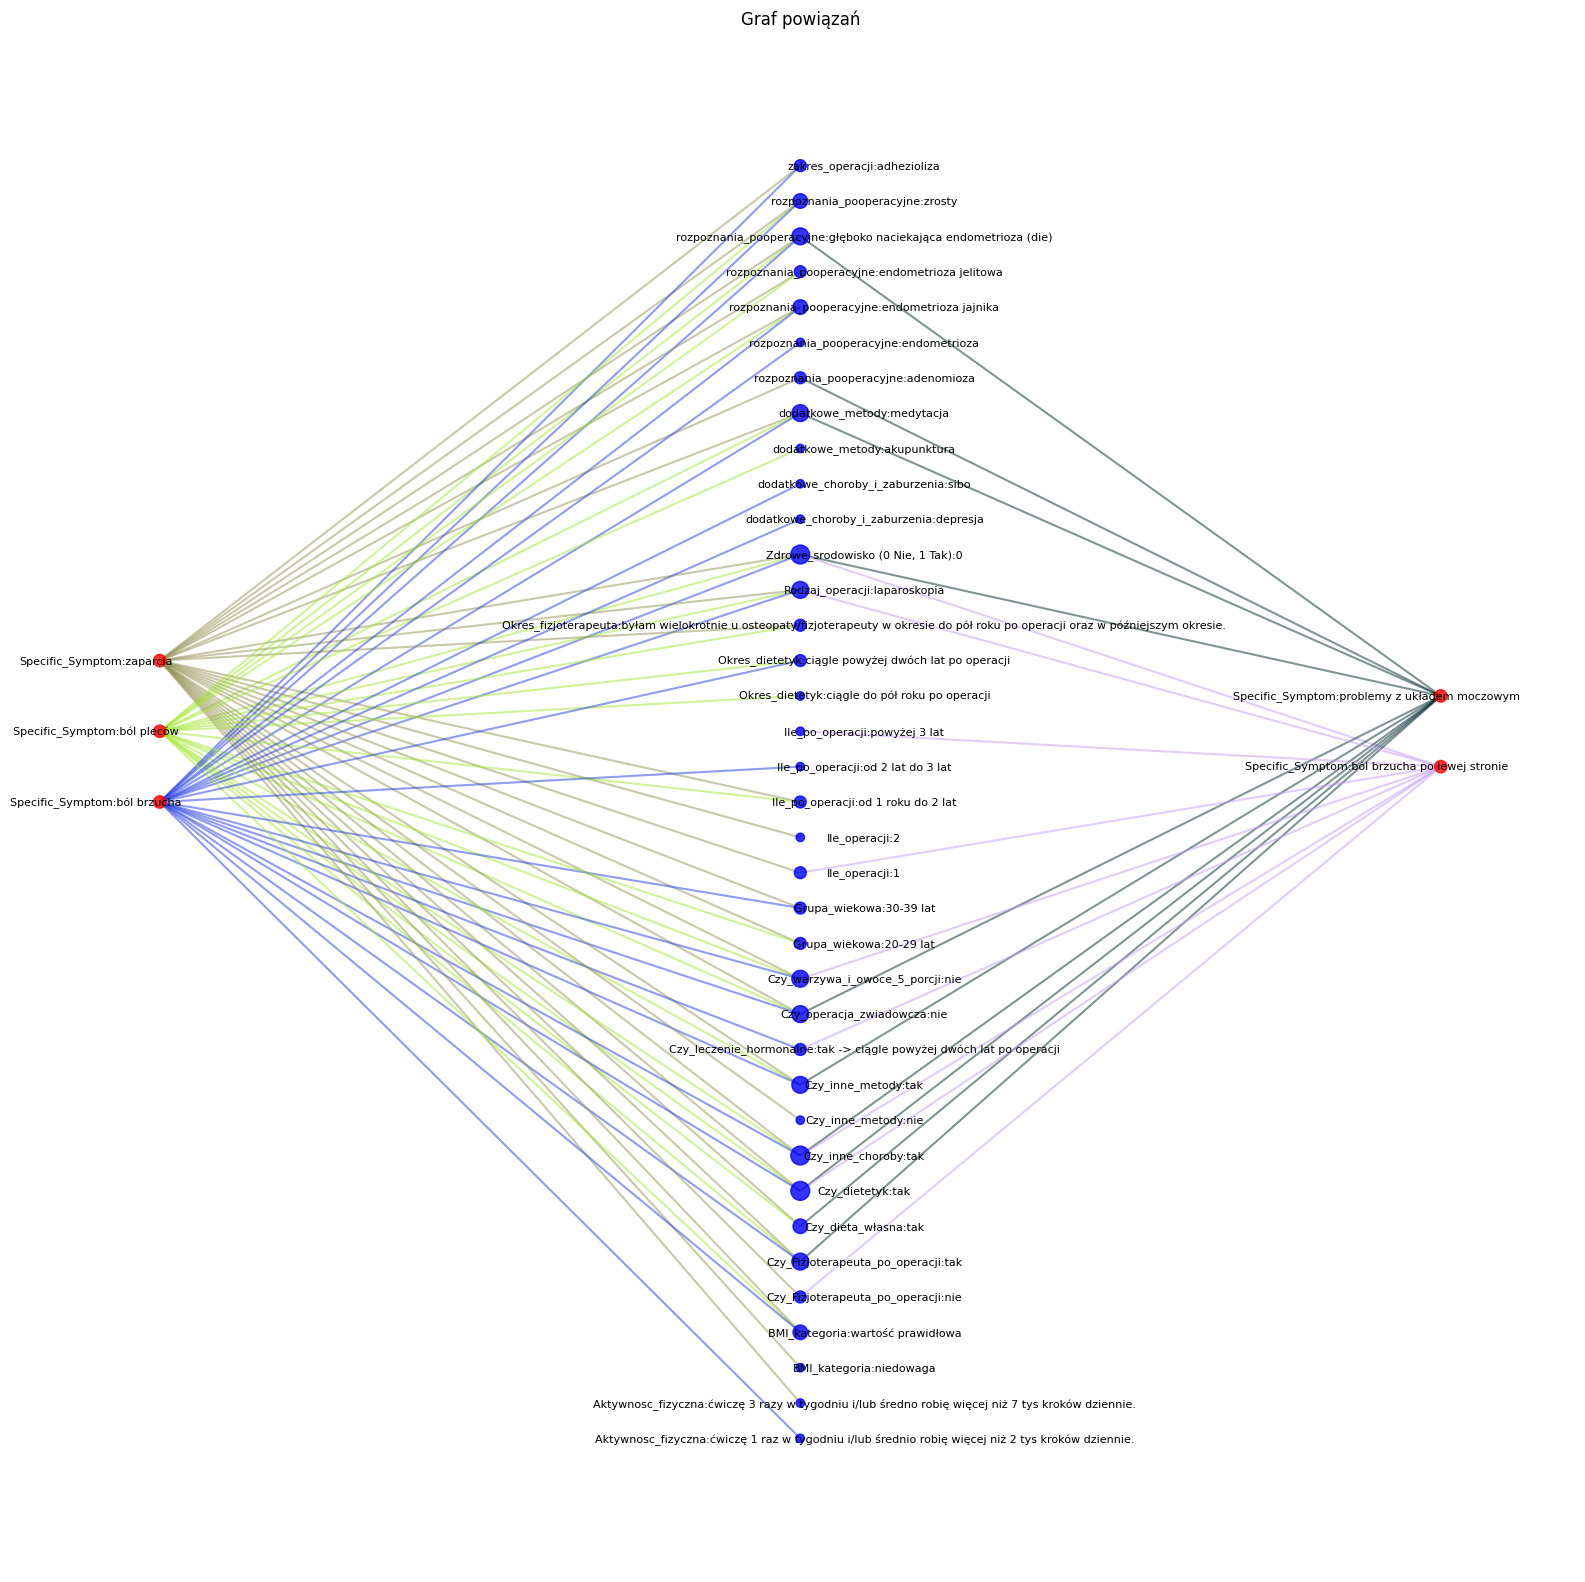

In [23]:
# Pobranie pliku CSV z folderu
result_folder = "results2"

random.seed(422)  # Ustawienie ziarna dla powtarzalności tego jak wygląda wykres

file_path = get_single_column_from_results_folder(result_folder)

if file_path:
    rules = pd.read_csv(file_path)
    if 'antecedents' in rules.columns and 'consequents' in rules.columns:
        rules['antecedents'] = rules['antecedents'].apply(eval)
        rules['consequents'] = rules['consequents'].apply(eval)
        G, degrees = prepare_graph_elements(rules)
    else:
        print("Błąd: brak wymaganych kolumn w pliku.")
else:
    print("Nie znaleziono pliku w folderze.")

pos = {}
y_offset = 60
x_cause = 0
x_effect_left = -1
x_effect_right = 1

causes = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'cause'])
effects = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'effect'])

max_cause_index = len(causes) - 1
max_effect_index = len(effects) - 1

for i, cause in enumerate(causes):
    pos[cause] = (x_cause, i * y_offset)

halfway_index = len(causes) // 2
for i, effect in enumerate(effects):
    if i % 2 == 0:
        pos[effect] = (x_effect_left, (halfway_index + i) * y_offset)
    else:
        pos[effect] = (x_effect_right, (halfway_index + i) * y_offset)

plt.figure(figsize=(20, 20))
node_colors = ['blue' if G.nodes[node]['type'] == 'cause' else 'red' for node in G.nodes]

default_effect_size = 80
node_size = [default_effect_size if G.nodes[node]['type'] == 'effect' else 1000 * (degrees[node] / max(degrees.values())) for node in G.nodes]

unique_effects = list(set(effects))
color_map = {effect: f'#{random.randint(0, 0xFFFFFF):06x}' for effect in unique_effects}

edge_colors = [color_map[G.edges[a, c]['effect']] for a, c in G.edges]

nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color=edge_colors)

for node in G.nodes:
    label_pos = (pos[node][0] + 0.1, pos[node][1]) if G.nodes[node]['type'] == 'cause' else (pos[node][0] - 0.1, pos[node][1])
    plt.text(label_pos[0], label_pos[1], node, fontsize=8, ha='center', va='center', color='black')

plt.title("Graf powiązań")
plt.axis('off')
plt.savefig("graf2_powiązań_cała_grupa_czynników_razem_alfabetycznie_w_pionie.png", format="PNG")
plt.show()


Na podstawie analizy asocjacyjnej biorącej pod uwagę wszystkie czynniki jednocześnie i na podstawie grafu wizualizującego powiązania, powiązań jest na tyle dużo, że nie jest łatwo wyłuskać najistotniejsze. Wiele dolegliwości jest powiązana z wieloma czynnikami i sposobami radzenia sobie. Czynniki lub metody radzenia sobie z chorobą, powiązane z pojedynczymi dolegliwościami to:

- zaparcia: tylko w grupie osób skarżących się na zaparcia widać powiązanie z osobami, które są po 2 operacjach, mają niedowagę, średnią aktywność fizyczną, nie stosują dodatkowych metod radzenia sobie z chorobą (typu fizjoterapia, masaże, akupunktura itp.), ale stosują dietę (od dietetyka lub własną),
- ból pleców: poza innymi metodami radzenia sobie z chorobą, tylko w grupie osób skarżących się na bóle pleców jest powiązanie z osobami stosującymi akupunkturę jako dodatkową metodę radzenia sobie z chorobą oraz stosującymi dietę przygotowaną przez dietetyka do pół roku po operacji,
- ból brzucha: tylko w grupie osób skarżących się na bóle brzucha widać powiązanie między tą dolegliwością a występowaniem depresji i SIBO, oraz z osobami, które są dłuższy czas po operacji (2-3 lata, lub powyżej 3 lat wskazywane przez osoby, które skarżą się na bóle brzucha po lewej stronie) i mają niską aktywność fizyczną.

# II. Analiza asocjacyjna dla przypadków występowania lub niewystępowania dolegliwości (TAK/NIE)

## II.1. Analiza asocjacyjna dla każdego z czynników z osobna:

In [24]:
# Funkcja do wstępnego przetwarzania danych -> UWAGA: TA FUNKCJA RÓŻNI SIĘ OD WCZEŚNIEJSZEJ TYM, ŻE TU NIE FILTRUJEMY PO TAK/NIE W KOLUMNIE CZY_DOLEGLIWOŚCI

def preprocess_data_all(df, specific_symptoms_col, factor_columns):
    df_filtered = df.copy()

    # Zamiana None/NaN oraz pojedynczych wartości na listy
    for col in df_filtered.columns:
        df_filtered[col] = df_filtered[col].apply(
            lambda x: [] if (x is None or (isinstance(x, float) and np.isnan(x)))
            else [x] if not isinstance(x, (list, np.ndarray)) else x
        )

    # Dodanie prefiksów do wartości dla zachowania kontekstu
    for col in factor_columns:
        df_filtered[col] = df_filtered[col].apply(lambda x: [f"{col}:{val}" for val in x])
    
    # Zamiana wartości w kolumnie Czy_dolegliwosci na listy
    df_filtered[specific_symptoms_col] = df_filtered[specific_symptoms_col].apply(
        lambda x: [f"Czy_dolegliwosci:{val}" for val in x]
    )

    # Scalanie kolumn w jedną listę transakcji
    df_filtered['Combined'] = df_filtered[factor_columns].apply(lambda row: sum(row, []), axis=1)
    df_filtered['Combined'] = df_filtered.apply(
        lambda row: row['Combined'] + row[specific_symptoms_col], axis=1
    )
    return df_filtered

In [25]:
# Główne wywołanie -> uwaga: ta funkcja różni się od poprzedniej tym, że tu bierze pod uwagę całość (nie wyfiltrowane dolegliwości tak/nie), min_support=0.06, min_confidence=0.7
def process_columns_all_lower(df, specific_symptoms_col, factor_columns):
    df_filtered = preprocess_data_all(df, specific_symptoms_col, factor_columns)
    final_rules = generate_rules_lower(df_filtered, specific_symptoms_col)
    return final_rules

In [26]:
# Główne wywołanie -> uwaga: ta funkcja różni się od poprzedniej tym, że tu bierze pod uwagę całość (nie wyfiltrowane dolegliwości tak/nie), min_support=0.07, min_confidence=0.85
def process_columns_all(df, specific_symptoms_col, factor_columns):
    df_filtered = preprocess_data_all(df, specific_symptoms_col, factor_columns)
    final_rules = generate_rules(df_filtered, specific_symptoms_col)
    return final_rules

In [27]:
# Lista kolumn do przetwarzania
columns_to_process = ['rozpoznania_pooperacyjne', 'zakres_operacji',
       'Rodzaj_operacji', 'Czy_leczenie_hormonalne',
       'Czy_dietetyk', 'Okres_dietetyk', 'Czy_dieta_własna',
       'Czy_Fizjoterapeuta_po_operacji', 'Okres_fizjoterapeuta',
       'Aktywnosc_fizyczna', 'Czy_inne_metody', 'dodatkowe_metody',
       'Czy_warzywa_i_owoce_5_porcji', 'Czy_inne_choroby',
       'dodatkowe_choroby_i_zaburzenia', 'Ile_operacji',
       'Czy_operacja_zwiadowcza', 'Ile_po_operacji',
       'Zdrowe_srodowisko (0 Nie, 1 Tak)', 'BMI_kategoria', 'Grupa_wiekowa']

# Tworzenie folderu "results" na wyniki
os.makedirs("results3", exist_ok=True)

# Iteracja przez kolumny i zapis wyników do plików CSV
for col in columns_to_process:
    try:
        print(f"Przetwarzanie kolumny: {col}")
        rules = process_columns_all_lower(df, 'Czy_dolegliwosci', [col])
        if not rules.empty:
            output_file = os.path.join("results3", f"rules_{col}.csv")
            rules.to_csv(output_file, index=False)
            print(f"Wyniki zapisano w pliku: {output_file}")
            print(f"Liczba znalezionych reguł: {len(rules)}")
        else:
            print(f"Nie znaleziono żadnych reguł dla kolumny: {col}")
    except Exception as e:
        print(f"Wystąpił błąd podczas przetwarzania kolumny {col}: {e}")


Przetwarzanie kolumny: rozpoznania_pooperacyjne
Wyniki zapisano w pliku: results3\rules_rozpoznania_pooperacyjne.csv
Liczba znalezionych reguł: 7
Przetwarzanie kolumny: zakres_operacji
Nie znaleziono żadnych reguł dla kolumny: zakres_operacji
Przetwarzanie kolumny: Rodzaj_operacji
Nie znaleziono żadnych reguł dla kolumny: Rodzaj_operacji
Przetwarzanie kolumny: Czy_leczenie_hormonalne
Nie znaleziono żadnych reguł dla kolumny: Czy_leczenie_hormonalne
Przetwarzanie kolumny: Czy_dietetyk
Nie znaleziono żadnych reguł dla kolumny: Czy_dietetyk
Przetwarzanie kolumny: Okres_dietetyk
Wyniki zapisano w pliku: results3\rules_Okres_dietetyk.csv
Liczba znalezionych reguł: 2
Przetwarzanie kolumny: Czy_dieta_własna
Nie znaleziono żadnych reguł dla kolumny: Czy_dieta_własna
Przetwarzanie kolumny: Czy_Fizjoterapeuta_po_operacji
Nie znaleziono żadnych reguł dla kolumny: Czy_Fizjoterapeuta_po_operacji
Przetwarzanie kolumny: Okres_fizjoterapeuta
Wyniki zapisano w pliku: results3\rules_Okres_fizjoterapeuta

### Wykonanie grafów

In [28]:
def save_graph_to_csv(G, col_name):
    # Utwórz folder 'grafy', jeśli nie istnieje
    folder_name = "grafy"
    os.makedirs(folder_name, exist_ok=True)
    
    # Zapis węzłów
    nodes = pd.DataFrame({
        'node_id': list(G.nodes),
        'type': ['symptom' if "Symptom:" in node else 'factor' for node in G.nodes]
    })
    nodes.to_csv(f"{folder_name}/{col_name}_nodes.csv", index=False)

    # Zapis krawędzi
    edges = pd.DataFrame(
        [(u, v, d['lift'], d['confidence']) for u, v, d in G.edges(data=True)],
        columns=['source', 'target', 'lift', 'confidence']
    )
    edges.to_csv(f"{folder_name}/{col_name}_edges.csv", index=False)

# Przygotowanie danych dla różnych kolumn
# Pobranie dostępnych kolumn z folderu 'results3'
result_folder = "results3"
columns_to_process = get_columns_from_results_folder(result_folder)
columns_to_process



['Aktywnosc_fizyczna',
 'BMI_kategoria',
 'dodatkowe_choroby_i_zaburzenia',
 'Grupa_wiekowa',
 'Ile_operacji',
 'Ile_po_operacji',
 'Okres_dietetyk',
 'Okres_fizjoterapeuta',
 'rozpoznania_pooperacyjne']

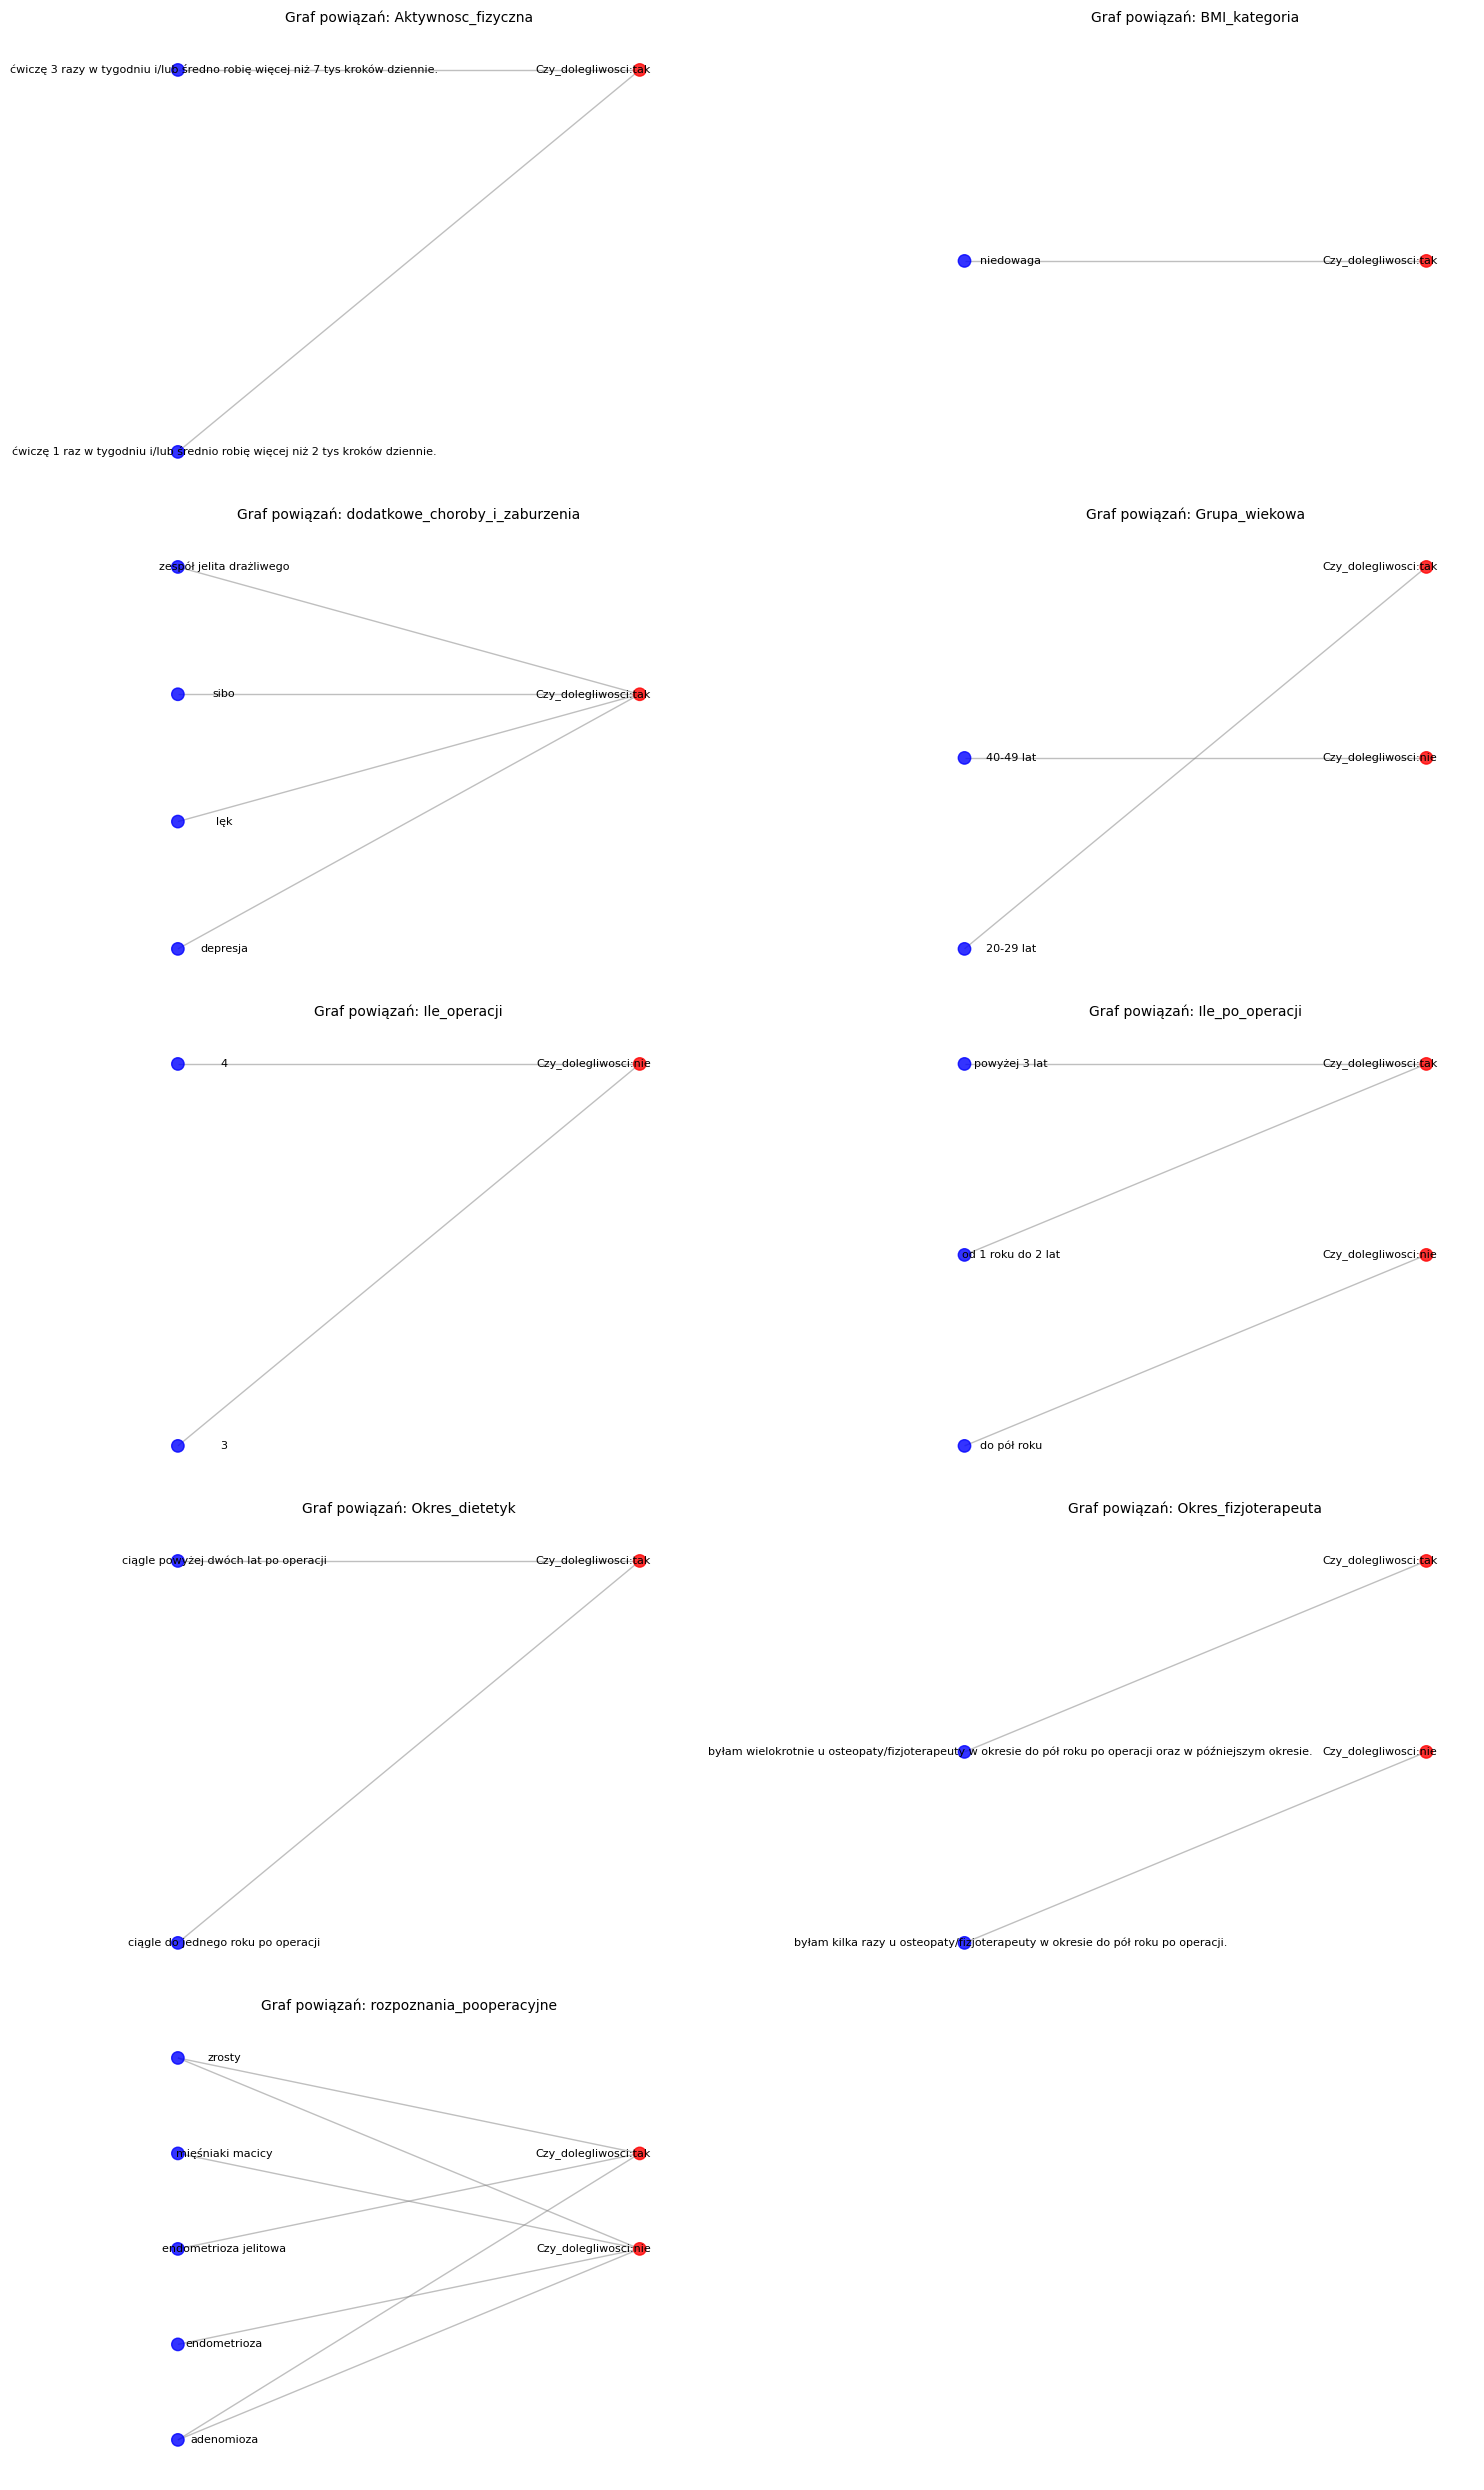

In [29]:
random.seed(0)

# Folder z plikami CSV
folder_path = "C:\\Users\\justy\\Documents\\Projekt\\results3"

# Pobranie listy plików CSV w folderze
files_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".csv")]

# Sprawdzenie, ile plików jest w folderze
num_files = len(files_paths)

if num_files == 0:
    print("Brak plików CSV w folderze.")
else:
    # Ustalanie liczby wierszy i kolumn w siatce
    ncols = 2  # Stała liczba kolumn
    nrows = math.ceil(num_files / ncols)  # Obliczenie liczby wierszy

    # Tworzenie dynamicznej figury
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, nrows * 5))
    axes = axes.flatten()  # Spłaszczenie listy osi dla łatwiejszego indeksowania

    # Przetwarzanie każdego pliku
    for idx, file_path in enumerate(files_paths):
        # Wczytanie i przetworzenie pliku CSV
        rules = pd.read_csv(file_path)

        # Konwersja kolumn na listy
        if 'antecedents' in rules.columns and 'consequents' in rules.columns:
            rules['antecedents'] = rules['antecedents'].apply(eval)
            rules['consequents'] = rules['consequents'].apply(eval)

            # Generowanie elementów grafu
            G, degrees = prepare_graph_elements(rules)
        else:
            print(f"Błąd: brak wymaganych kolumn w pliku {file_path}.")
            continue

        # Ustalanie pozycji węzłów
        pos = {}
        y_offset = 150  # Zwiększenie odstępu między węzłami
        x_cause = 0  # Pozycja X dla przyczyn (lewa strona)
        x_effect_left = -1  # Pozycja X dla efektów po lewej
        x_effect_right = 1  # Pozycja X dla efektów po prawej

        # Sortowanie węzłów alfabetycznie
        causes = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'cause'])
        effects = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'effect'])

        # Wyśrodkowanie węzłów efektów względem przyczyn
        halfway_index = len(causes) // 2  # Pozycja połowy przyczyn
        for i, cause in enumerate(causes):
            pos[cause] = (x_cause, i * y_offset)  # Przyczyny w pionie

        # # Ustalenie pozycji dla skutków
        for i, effect in enumerate(effects):
            pos[effect] = (x_effect_right, (halfway_index + i) * y_offset)
        
        # Wybór odpowiedniej osi
        ax = axes[idx]

        # Tworzenie tytułu wykresu na podstawie przyczyny
        if isinstance(rules.iloc[0]['antecedents'], frozenset):
            cause_label = list(rules.iloc[0]['antecedents'])[0].split(":")[0]
        else:
            cause_label = str(rules.iloc[0]['antecedents']).split(":")[0]

        ax.set_title(f"Graf powiązań: {cause_label}", fontsize=10)

        # Rysowanie grafu
        node_colors = ['blue' if G.nodes[node]['type'] == 'cause' else 'red' for node in G.nodes]

        # Stała wielkość dla czerwonych kropek (skutków)
        default_effect_size = 80

        # Dla przyczyn (niebieskie kropki)
        node_size = 80

        nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8, ax=ax)
        nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5, edge_color='gray', ax=ax)

        # Rysowanie etykiet węzłów
        for node in G.nodes:
            label = extract_label_from_node(node)
            if G.nodes[node]['type'] == 'cause':
                label_pos = (pos[node][0] + 0.1, pos[node][1])  # Etykieta po prawej stronie dla przyczyny
                ax.text(label_pos[0], label_pos[1], label, fontsize=8, ha='center', va='center', color='black')
            else:
                label_pos = (pos[node][0] - 0.1, pos[node][1])  # Etykieta po lewej stronie dla skutku
                ax.text(label_pos[0], label_pos[1], node, fontsize=8, ha='center', va='center', color='black')

        ax.axis('off')  # Ukrycie osi

    # Usuwanie pustych osi, jeśli istnieją
    for ax in axes[num_files:]:
        ax.axis("off")

    plt.tight_layout()
    
    
# Zapis wykresów do pliku
plt.savefig("graf_3_powiązań_cząstkowy_tak_nie_alfabetycznie_w_pionie.png", format="PNG")	

plt.show()


Na podstawie analizy asocjacyjnej wykonanej dla okoliczności występowania lub nie występowania dolegliwości i wizualizacji powiązań za pomocą grafu wnioski są następujące:

Na występowanie dolegliwości najczęściej skarżą się osoby o małej lub średniej aktywności fizycznej, ale nie o siedzącym trybie życia i dużej aktywności.
Najczęściej na występowanie dolegliwości skarżą się osoby mające niedowagę, między 20 a 29 rokiem życia, są ponad rok po operacji (i dłużej). Dolegliwości występują mimo ciągłego korzystania z diety przygotowanej przez dietetyka nawet powyżej 2 lat po operacji. Dolegliwości występują również mimo wielokrotnego korzystania z fizjoterapii i/lub osteopatii do pół roku po operacji. Najczęściej współwystępujące choroby i zaburzenia to: zespół jelita drażliwego, SIBO, depresja i lęk.
Najczęściej występowanie dolegliwości jest związane z rozpoznaniami pooperacyjnymi takimi jak: endometrioza jelitowa, adenomioza, zrosty.

Osoby, które nie mają dolegliwości najczęściej są w wieku pomiędzy 40-49 lat. Najczęściej są do pół roku po operacji, mają za sobą 3-4 operacje. Miały takie rozpoznania pooperacyjne jak: zrosty, mięśniaki macicy oraz endometrioza bez wskazania szczegółowego jej lokalizacji oraz bez wskazania na stopień zaawansowania. Do pół roku po operacji były kilka razy u fizjoterapeuty i/lub osteopaty. Jak wyżej wspomniano osoby, które skarżą się na dolegliwości częściej były wielokrotnie u fizjoterapeuty i/lub osteopaty, tak więc z niniejsza analiza wskazuje, że fizjoterapia/osteopatia może nie mieć wpływu na występowanie lub nie występowanie dolegliwości.

## II.2. Analiza powiązań dla grupy czynników:

In [30]:
columns_to_process = ['rozpoznania_pooperacyjne', 'zakres_operacji',
       'Rodzaj_operacji', 'Czy_leczenie_hormonalne',
       'Czy_dietetyk', 'Okres_dietetyk', 'Czy_dieta_własna',
       'Czy_Fizjoterapeuta_po_operacji', 'Okres_fizjoterapeuta',
       'Aktywnosc_fizyczna', 'Czy_inne_metody', 'dodatkowe_metody',
       'Czy_warzywa_i_owoce_5_porcji', 'Czy_inne_choroby',
       'dodatkowe_choroby_i_zaburzenia', 'Ile_operacji',
       'Czy_operacja_zwiadowcza', 'Ile_po_operacji',
       'Zdrowe_srodowisko (0 Nie, 1 Tak)', 'BMI_kategoria', 'Grupa_wiekowa']

os.makedirs("results4", exist_ok=True)

try:
    print("Przetwarzanie wszystkich kolumn jednocześnie")
    rules = process_columns_all(df, 'Czy_dolegliwosci', columns_to_process)
    if not rules.empty:
        output_file = os.path.join("results4", "rules_all_columns.csv")
        rules.to_csv(output_file, index=False)
        print(f"Wyniki zapisano w pliku: {output_file}")
        print(f"Liczba znalezionych reguł: {len(rules)}")
    else:
        print("Nie znaleziono żadnych reguł.")
except Exception as e:
    print(f"Wystąpił błąd: {e}")


Przetwarzanie wszystkich kolumn jednocześnie
Wyniki zapisano w pliku: results4\rules_all_columns.csv
Liczba znalezionych reguł: 5683


### Graf związków przyczynowo-skutkowych dla całej grupy czynników:

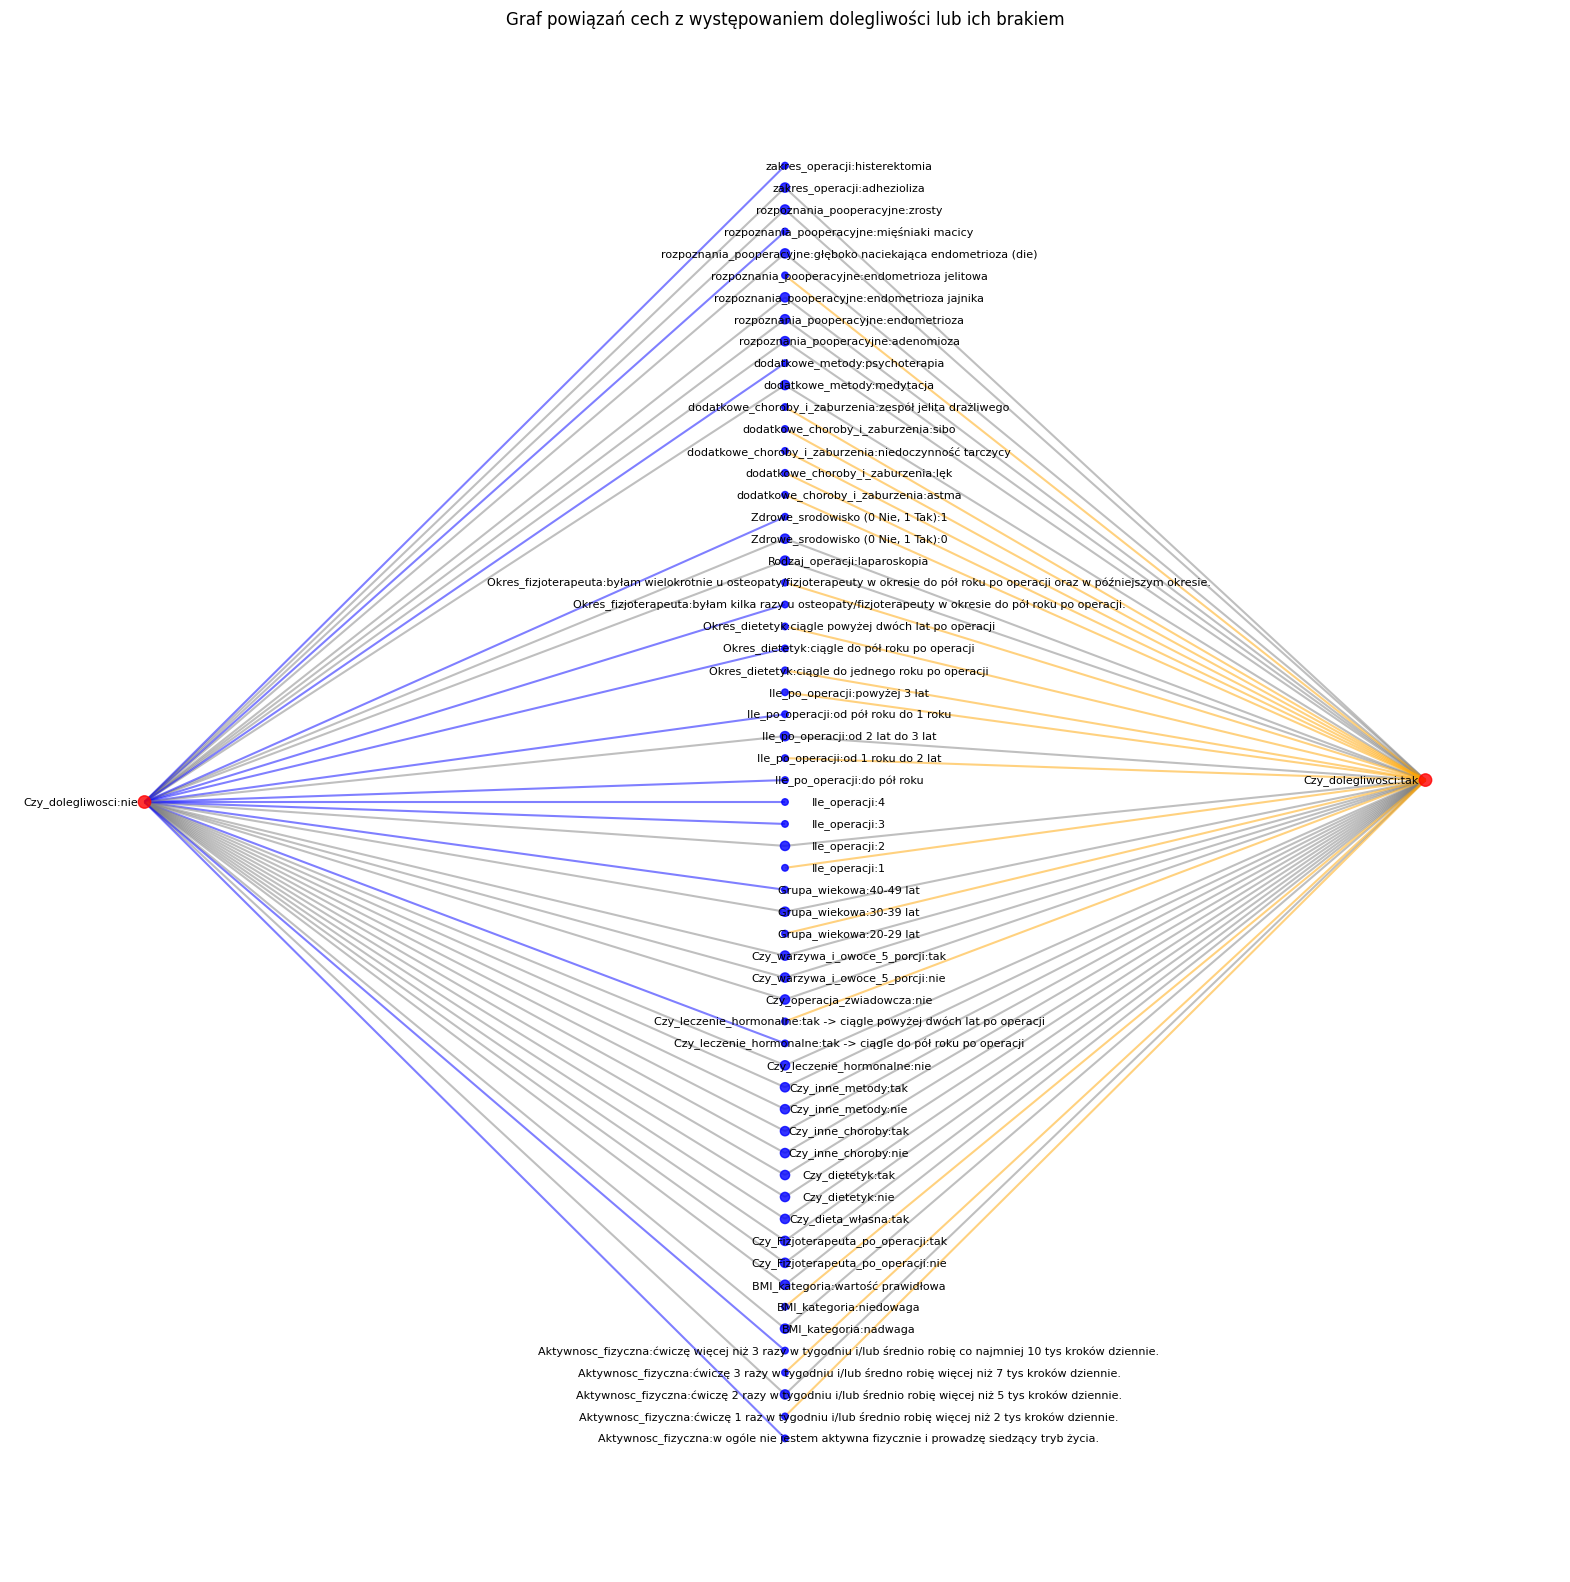

In [31]:
# Pobranie pliku CSV z folderu
result_folder = "results4"

file_path = get_single_column_from_results_folder(result_folder)

# Wczytanie i przetworzenie pliku CSV
if file_path:
    rules = pd.read_csv(file_path)

    # Konwersja kolumn na listy
    if 'antecedents' in rules.columns and 'consequents' in rules.columns:
        rules['antecedents'] = rules['antecedents'].apply(eval)
        rules['consequents'] = rules['consequents'].apply(eval)

        # Generowanie elementów grafu
        G, degrees = prepare_graph_elements(rules)
    else:
        print("Błąd: brak wymaganych kolumn w pliku.")
else:
    print("Nie znaleziono pliku w folderze.")

# Ustalanie pozycji węzłów
pos = {}
y_offset = 60  # Zwiększenie odstępu między węzłami
x_cause = 0  # Pozycja X dla przyczyn (lewa strona)
x_effect_left = -1  # Pozycja X dla efektów po lewej
x_effect_right = 1  # Pozycja X dla efektów po prawej

# Sortowanie węzłów alfabetycznie
causes = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'cause'])
effects = sorted([node for node in G.nodes if G.nodes[node]['type'] == 'effect'])

# Wyśrodkowanie węzłów efektów względem przyczyn
max_cause_index = len(causes) - 1  # Indeks ostatniej przyczyny
max_effect_index = len(effects) - 1  # Indeks ostatniego skutku

# Ustalenie pozycji dla przyczyn
for i, cause in enumerate(causes):
    pos[cause] = (x_cause, i * y_offset)  # Przyczyny w pionie

# Ustalenie pozycji dla skutków (na zmianę raz po lewej, raz po prawej)
halfway_index = len(causes) // 2  # Pozycja połowy przyczyn
for i, effect in enumerate(effects):
    if i % 2 == 0:  # Parzyste efekty po lewej stronie
        pos[effect] = (x_effect_left, (halfway_index + i) * y_offset)
    else:  # Nieparzyste efekty po prawej stronie
        pos[effect] = (x_effect_right, (halfway_index + i) * y_offset)

# Wizualizacja grafu
plt.figure(figsize=(20, 20))  # rozmiar figury
node_colors = ['blue' if G.nodes[node]['type'] == 'cause' else 'red' for node in G.nodes]

# Stała wielkość dla czerwonych kropek (skutków)
default_effect_size = 80

# Dla przyczyn (niebieskie kropki), rozmiar zależy od stopnia połączenia
node_size = [default_effect_size if G.nodes[node]['type'] == 'effect' else 1000 * (degrees[node] / max(degrees.values())) for node in G.nodes]


# Lista krawędzi z kolorami - linie odchodzące od Tak będą pomarańczowe, od Nie będą niebieskie, a jeśli odchodzą od obu, będą szare:
edge_colors = []

# Słownik do przechowywania węzłów powiązanych z "Czy_dolegliwosci:Tak" i "Czy_dolegliwosci:Nie"
tak_edges = {}
nie_edges = {}

for a, c in G.edges:
    # Jeśli krawędź zawiera "Czy_dolegliwosci:Tak", zapisz ją
    if "Czy_dolegliwosci:tak" in [a, c]:
        other_node = c if a == "Czy_dolegliwosci:tak" else a
        if other_node not in tak_edges:
            tak_edges[other_node] = []
        tak_edges[other_node].append((a, c))  # Dodaj krawędź do "Czy_dolegliwosci:tak"

    # Jeśli krawędź zawiera "Czy_dolegliwosci:nie", zapisz ją
    if "Czy_dolegliwosci:nie" in [a, c]:
        other_node = c if a == "Czy_dolegliwosci:nie" else a
        if other_node not in nie_edges:
            nie_edges[other_node] = []
        nie_edges[other_node].append((a, c))  # Dodaj krawędź do "Czy_dolegliwosci:nie"

# Sprawdzam, które węzły są wspólne dla obu krawędzi i przypisuję odpowiedni kolor
for a, c in G.edges:
    # Badam węzły po obu stronach krawędzi
    nodes_in_edge = {a, c}
    
    # Jeśli oba węzły znajdują się w obu słownikach (i zawierają zarówno "Tak" jak i "Nie"):
    if a in tak_edges and a in nie_edges:
        edge_colors.append("gray")
    elif c in tak_edges and c in nie_edges:
        edge_colors.append("gray")
    elif "Czy_dolegliwosci:tak" in nodes_in_edge:
        edge_colors.append("orange")  # Kolor pomarańczowy dla Tak
    elif "Czy_dolegliwosci:nie" in nodes_in_edge:
        edge_colors.append("blue")  # Kolor niebieski dla Nie
    else:
        edge_colors.append("gray")  # Kolor domyślny


# Rysowanie węzłów
nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.8)

# Rysowanie krawędzi z odpowiednimi kolorami
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.5, edge_color=edge_colors)

# Rysowanie etykiet węzłów
for node in G.nodes:
    label_pos = (pos[node][0] + 0.1, pos[node][1]) if G.nodes[node]['type'] == 'cause' else (pos[node][0] - 0.1, pos[node][1])
    plt.text(label_pos[0], label_pos[1], node, fontsize=8, ha='center', va='center', color='black')


# Pokazanie wykresu
plt.title("Graf powiązań cech z występowaniem dolegliwości lub ich brakiem")
plt.axis('off')  # Ukrywa osie

# Zapis wykresu do pliku
plt.savefig("graf_4_powiązań_całość_tak_nie_alfabetycznie_w_pionie.png", format="PNG")

# Pokazanie wykresu
plt.show()


Analiza grafu uwzględniającego występowanie lub brak dolegliwości pozwala sformułować następujące wnioski:

Osoby, które nie skarżą się na dolegliwości, w porównaniu do osób odczuwających dolegliwości:
- Przeszły histerektomię (usunięcie macicy). Oprócz endometriozy miały również mięśniaki macicy.
- W ramach dodatkowych metod radzenia sobie z chorobą stosują psychoterapię.
- Mieszkają w środowisku określonym w analizie jako „zdrowe” – w miastach poniżej 100 tys. mieszkańców, bez smogu i dużych zakładów przemysłowych.
- Mają za sobą 3-4 operacje.
- Są w wieku 40-49 lat.

Analiza asocjacyjna wskazuje, że w zbiorze danych nie występuje istotna liczba przypadków, w których dodatkowe choroby współwystępowałyby z brakiem dolegliwości po operacjach.

Osoby, które skarżą się na dolegliwości po operacji endometriozy, w porównaniu do osób ich nieodczuwających:
- Częściej miały endometriozę jelitową.
- Chorują dodatkowo na zespół jelita drażliwego (IBS), SIBO, niedoczynność tarczycy i astmę oraz mają lęki.
- Są młodsze niż osoby, które nie odczuwają dolegliwości po operacji.
- Tylko w tej grupie zaobserwowano powiązanie z niedowagą.


Czynniki niewykazujące istotnego wpływu na występowanie dolegliwości po operacji: korzystanie ze zdrowej diety, fizjoterapii/osteopatii, leczenie hormonalne, aktywność fizyczna oraz okres po operacji.


# Podsumowanie i wnioski

Największym wyzwaniem w projekcie było takie przetworzenie danych, aby możliwe było wyciągnięcie wiarygodnych i spójnych wniosków. W tym celu do analizy danych pochodzących z ankiet wykorzystałam model LLM GPT-4o. Przetestowałam również model Ollama3 oraz modele z Hugging Face przeznaczone do tłumaczenia tekstów, jednak żaden z nich nie zapewnił satysfakcjonujących wyników. Spośród wszystkich testowanych modeli GPT-4o okazał się najskuteczniejszy i to właśnie jego zastosowałam w całym projekcie. Dodatkowo sprawdziłam możliwość wykorzystania jednostek nazwanych (entities) z biblioteki SciSpaCy, jednak ta metoda również nie przyniosła rezultatów nadających się do dalszej analizy.

Ponieważ przetwarzanie danych odbywało się przy użyciu niedoskonałego modelu LLM, z pewnością doszło do pewnej utraty informacji. Mimo to, w kontekście analizy języka naturalnego, rozwiązanie to było bardzo efektywne. Ręczne przetworzenie dużej ilości tego typu danych byłoby niezwykle czasochłonne. Co więcej, zastosowanie modelu LLM pozwoliło uniknąć konieczności zatrudnienia specjalisty do manualnego dopasowywania dolegliwości i jednostek chorobowych do opisów respondentów – proces ten został zautomatyzowany.

Niestety, liczba zebranych ankiet była niewielka – jedynie 57 wypełnionych formularzy. Oznacza to, że wnioski płynące z tej analizy nie mogą być bezpośrednio uogólnione na całą populację osób operowanych z powodu endometriozy. Jednak gdyby dostępna była większa ilość danych, zastosowanie modeli LLM w połączeniu z analizą asocjacyjną, tak jak w niniejszym projekcie, mogłoby dostarczyć cennych i istotnych informacji dotyczących występowania lub braku problemów zdrowotnych po operacjach endometriozy.

Na podstawie przeprowadzonej analizy asocjacyjnej można sformułować następujące wnioski dotyczące postawionych hipotez na początku projektu:

- Hipoteza: Przewlekłe dolegliwości po operacjach są rzadkie.

Wniosek: Hipoteza ta nie została potwierdzona. Analiza wykazała, że 45,6% respondentów nie doświadcza przewlekłych dolegliwości po operacjach endometriozy, natomiast pozostałe 54,4% zgłasza ich występowanie. Wskazuje to na to, że przewlekłe dolegliwości nie są rzadkie, lecz dotyczą znacznej części badanej grupy.

- Hipoteza: Przewlekłe dolegliwości po operacjach są zależne od zakresu operacji.

Wniosek: Hipoteza ta została częściowo potwierdzona. Osoby, które nie odczuwają dolegliwości, częściej przeszły histerektomię co sugeruje związek między zakresem operacji a występowaniem przewlekłych dolegliwości. Natomiast osoby z dolegliwościami częściej miały operowaną endometriozę jelitową, miały endometriozę głęboko naciekającą, endometriozę więzadła krzyżowo-macicznego i adenomiozę co sugeruje związek między lokalizacją endometriozy a występowaniem przewlekłych dolegliwości.

- Hipoteza: Przewlekłe dolegliwości po operacjach są bardzo zróżnicowane, ale niezależne od stosowanych diet, fizjoterapii i innych sposobów na poprawianie stanu organizmu, występują niezależnie od istnienia współistniejących chorób oraz są niezależne od stanu środowiska naturalnego w miejscu zamieszkania.

Wniosek: Hipoteza ta została częściowo obalona. Analiza wykazała, że:

Dolegliwości rzeczywiście są bardzo zróżnicowane.
Stosowanie zdrowej diety, fizjoterapii/osteopatii, leczenie hormonalne oraz aktywność fizyczna nie wykazują istotnego wpływu na występowanie dolegliwości, co potwierdza część hipotezy.
Natomiast istnienie współistniejących chorób, takich jak zespół jelita drażliwego (IBS), SIBO, niedoczynność tarczycy, astma oraz lęki, jest związane z występowaniem przewlekłych dolegliwości, co przeczy założeniu o ich niezależności od współistniejących schorzeń.
Środowisko naturalne ma znaczenie – osoby nieodczuwające dolegliwości częściej mieszkają w „zdrowym” środowisku (miasta poniżej 100 tys. mieszkańców, bez smogu i dużych zakładów przemysłowych). To przeczy założeniu o braku wpływu czynników środowiskowych.
Podsumowując, analiza potwierdziła część hipotez, jednocześnie wskazując na znaczenie zakresu operacji, współistniejących schorzeń oraz czynników środowiskowych w występowaniu przewlekłych dolegliwości po operacjach endometriozy.